In [1422]:
import pandas as pd
import numpy as np

# Plotting and correlation
import matplotlib.pyplot as plt
from scipy import stats

# Model
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import RidgeCV

import warnings
warnings.filterwarnings('ignore')

Compilation of final data analyses based on exploratory notebooks. We generate realistic electricity-powered vehicle numbers based on different EV proportions in two different ways. We predict electricity demand in California based on these distributions and calculate energy generation-related emissions.

**Load data**

In [1423]:
# monthly CA CO2 emissions (mTCO2)

emissions = pd.read_csv('data/cleaned/monthly_emissions.csv')
emissions.rename(columns={'Unnamed: 0':'date'},inplace=True)
emissions.head()


,date,emissions
0,201401,5615497.820
1,201402,5022762.297
2,201403,5289480.524
3,201404,4812433.460
4,201405,5331965.630


In [1424]:
# CA monthly demand (MWh)

demand = pd.read_csv('data/cleaned/monthly_demand.csv')
demand = demand.rename(columns={'Unnamed: 0':'date'})
demand.head()

,date,demand
0,202211,18098856
1,202210,22583054
2,202209,27240453
3,202208,29002852
4,202207,26935101


In [1425]:
# CA monthly vehicle distribution

fuel_types = ['electric','plug-in hybrid electric','fuel cell','diesel','flex fuel','gasoline','gasoline hybrid','natural gas fuel','propane']
vehicles = pd.read_csv('data/cleaned/monthly_vehicles.csv')
vehicles = vehicles.drop(columns=['Unnamed: 0']) 
vehicles.head()

,date,electric,plug-in hybrid electric,fuel cell,diesel,flex fuel,gasoline,gasoline hybrid,natural gas fuel,propane,total,date_idx
0,202112,522445,305315,10127,590216,1208970,25998618,1298275,8461,90,29942517,132
1,202111,505951,300973,9877,599395,1203600,25917181,1285769,8395,157,29836132,131
2,202110,490400,297256,9627,608574,1198231,25835745,1275167,8330,224,29729751,130
3,202109,476248,292462,9377,617753,1192861,25754308,1263823,8264,291,29623366,129
4,202108,462251,289169,9127,626932,1187492,25672872,1253083,8199,359,29516987,128


In [1426]:
# monthly maximum temperature in each CA county (degrees Fahrenheit)

tmax = pd.read_csv('data/cleaned/monthly_tmax.csv')
tmax = tmax.drop(columns=['Unnamed: 0'])
tmax.head()

,date,county 1 tmax,county 3 tmax,county 5 tmax,county 7 tmax,county 9 tmax,county 11 tmax,county 13 tmax,county 15 tmax,county 17 tmax,...,county 101 tmax,county 103 tmax,county 105 tmax,county 107 tmax,county 109 tmax,county 111 tmax,county 113 tmax,county 115 tmax,mean tmax,date_idx
0,201501,61.0,48.5,59.9,61.0,60.2,61.9,60.1,54.7,57.2,...,60.6,61.0,54.5,53.1,54.4,64.1,61.2,61.4,59.558621,1
1,201502,65.4,50.9,63.7,65.3,64.8,67.3,66.1,55.9,59.4,...,67.8,63.5,57.6,60.8,57.4,66.4,67.3,66.3,64.100000,2
2,201503,70.8,53.5,69.3,71.3,70.0,74.6,72.2,60.7,63.8,...,76.1,69.1,64.1,65.5,60.7,71.4,74.5,72.5,69.410345,3
3,201504,69.6,52.2,68.4,72.2,69.3,76.2,71.6,60.9,63.1,...,78.1,70.8,64.9,65.1,59.6,68.6,76.8,73.3,69.055172,4
4,201505,68.8,55.9,72.7,76.8,73.2,80.0,71.1,67.3,67.5,...,81.5,75.4,71.7,67.9,62.3,68.7,79.4,77.7,71.446552,5


In [1427]:
# monthly average precipitation in each CA county (inches)

precip = pd.read_csv('data/cleaned/monthly_precip.csv')
precip = precip.drop(columns=['Unnamed: 0'])
precip.head()

,date,county 1 precip,county 3 precip,county 5 precip,county 7 precip,county 9 precip,county 11 precip,county 13 precip,county 15 precip,county 17 precip,...,county 101 precip,county 103 precip,county 105 precip,county 107 precip,county 109 precip,county 111 precip,county 113 precip,county 115 precip,mean precip,date_idx
0,201501,0.01,0.22,0.14,0.21,0.13,0.18,0.01,3.49,0.12,...,0.10,0.25,1.79,0.47,0.14,1.97,0.06,0.08,0.440345,1
1,201502,2.25,5.53,5.36,4.58,5.26,3.66,2.34,11.17,6.96,...,2.49,4.29,11.74,2.29,5.12,0.88,3.20,4.42,3.597241,2
2,201503,0.26,0.62,0.83,0.58,0.64,0.54,0.26,5.65,0.87,...,0.17,1.04,2.53,0.43,0.68,0.69,0.17,0.48,0.722759,3
3,201504,1.15,2.52,3.09,2.24,2.64,1.78,1.09,4.36,3.41,...,1.52,1.76,2.03,0.87,3.29,0.32,1.31,2.75,1.556897,4
4,201505,0.37,2.99,1.39,0.29,1.18,0.08,0.20,0.68,1.96,...,0.03,0.61,1.23,1.76,2.70,0.61,0.10,0.17,0.862759,5


**Generate vehicle distribution**

From 4_vehicle_prediction.ipynb. Given a date and a set of growth rates for each vehicle type, predict vehicle distribution. We also get the average temperature and precipitation for that month

In [1428]:
# Get dataset
df = vehicles
df.head()

,date,electric,plug-in hybrid electric,fuel cell,diesel,flex fuel,gasoline,gasoline hybrid,natural gas fuel,propane,total,date_idx
0,202112,522445,305315,10127,590216,1208970,25998618,1298275,8461,90,29942517,132
1,202111,505951,300973,9877,599395,1203600,25917181,1285769,8395,157,29836132,131
2,202110,490400,297256,9627,608574,1198231,25835745,1275167,8330,224,29729751,130
3,202109,476248,292462,9377,617753,1192861,25754308,1263823,8264,291,29623366,129
4,202108,462251,289169,9127,626932,1187492,25672872,1253083,8199,359,29516987,128


In [1429]:
# given date of YEARMONTH format, get date_idx

NUM_MONTHS = 12
FIRST_YEAR = 2014

def to_index(date):
    date_year = int(str(date)[0:4])
    if date_year < 2014:
        print('Date must be 2014 or later')
    date_month = int(str(date)[4:6])
    if date_month < 0 or date_month > NUM_MONTHS:
        print('Invalid month')
    months_to_curr_year = (date_year - FIRST_YEAR) * NUM_MONTHS
    date_idx = months_to_curr_year + date_month - 1
    return date_year, date_month, date_idx 


In [1430]:
# given date of YEARMONTH format and which fits to use for each vehicle type, predict vehicle distribution

def predict_distribution(date, fit_list):
    year, month, test_date_idx = to_index(date)

    print(f'In month {month} of {year} or date index {test_date_idx}, we predict:')

    X = vehicles['date_idx']
    vehicle_distribution = {}
    for fuel in fuel_types:
        y = vehicles[fuel]
        fit = fit_list[fuel]
        poly_model = np.poly1d(np.polyfit(X, y, fit))
        predicted_vehicles = int(poly_model(test_date_idx))
        if predicted_vehicles < 0:
            predicted_vehicles = 0
        vehicle_distribution[fuel] = predicted_vehicles

    total_vehicles = sum(list(vehicle_distribution.values()))
    print(f'Total vehicles: {total_vehicles}')
    for vehicle in vehicle_distribution:
        num_vehicles = vehicle_distribution[vehicle]
        percentage = round(num_vehicles/total_vehicles * 100, 2)
        print(f'Estimated number of {vehicle} vehicles: {num_vehicles} or {percentage}%')
    
    return test_date_idx, vehicle_distribution

In [1431]:
# Given a date, find the average max. temperature and precipitation for that month
def weather_avg(date):
    month = str(date)[4:]
    date_idx = int(month)
    tmax_sum = 0
    precip_sum = 0
    counter = 0
    while date_idx in list(tmax['date_idx']):
        tmax_sum += float(tmax.loc[tmax['date_idx'] == date_idx, 'mean tmax'])
        precip_sum += float(precip.loc[precip['date_idx'] == date_idx, 'mean precip'])
        date_idx += 12
        counter += 1
    tmax_avg = tmax_sum/counter
    precip_avg = precip_sum/counter
    return tmax_avg, precip_avg

In [1455]:
# input
date = 202608 # August 2026

fit_list = {
    'electric': 3, # 2: least optimistic growth, 6: extremely optimistic growth
    'plug-in hybrid electric': 3,
    'fuel cell': 3,
    'gasoline hybrid': 3,
    'flex fuel': 2,
    'gasoline': 2, # 2: neutral growth, 3: decline
    'diesel': 4,
    'natural gas fuel': 4,
    'propane': 4
}

# get vehicle prediction
test_date_idx, vehicle_distribution = predict_distribution(date, fit_list)

# get weather averages
tmax_avg, precip_avg = weather_avg(date)
print()
print(f'In month {str(date)[4:]}, average for 2015-2022:')
print(f'Max temperature : {round(tmax_avg,2)}')
print(f'Precipitation: {round(precip_avg,2)}')

In month 8 of 2026 or date index 151, we predict:
Total vehicles: 31489867
Estimated number of electric vehicles: 699835 or 2.22%
Estimated number of plug-in hybrid electric vehicles: 312033 or 0.99%
Estimated number of fuel cell vehicles: 12573 or 0.04%
Estimated number of diesel vehicles: 379989 or 1.21%
Estimated number of flex fuel vehicles: 1224642 or 3.89%
Estimated number of gasoline vehicles: 27575770 or 87.57%
Estimated number of gasoline hybrid vehicles: 1276945 or 4.06%
Estimated number of natural gas fuel vehicles: 8080 or 0.03%
Estimated number of propane vehicles: 0 or 0.0%

In month 08, average for 2015-2022:
Max temperature : 88.93
Precipitation: 0.1


In [1433]:
predicted_weather = [tmax_avg, precip_avg]

predicted_electric = vehicle_distribution['electric']
predicted_plug_in_hybrid = vehicle_distribution['plug-in hybrid electric']

# input for next step
demand_input = [predicted_electric, predicted_plug_in_hybrid] + predicted_weather

demand_input

[699835, 312033, 88.92844827586208, 0.09525862068965511]

**Predicting demand**

From 3_vehicle_to_demand.ipynb. Predict electricity demand for CA given the number of EVs, number of plug-in hyrid, and weather data generated above

In [1434]:
# Get dataset

df = demand.merge(vehicles)
df = df.merge(tmax[['date','mean tmax']], left_on='date', right_on='date')
df = df.merge(precip[['date','mean precip']], left_on='date', right_on='date')
df.head()

,date,demand,electric,plug-in hybrid electric,fuel cell,diesel,flex fuel,gasoline,gasoline hybrid,natural gas fuel,propane,total,date_idx,mean tmax,mean precip
0,202112,22418337,522445,305315,10127,590216,1208970,25998618,1298275,8461,90,29942517,132,51.368966,8.301379
1,202111,20251317,505951,300973,9877,599395,1203600,25917181,1285769,8395,157,29836132,131,64.374138,1.324310
2,202110,21604672,490400,297256,9627,608574,1198231,25835745,1275167,8330,224,29729751,130,69.306897,5.433276
3,202109,24859626,476248,292462,9377,617753,1192861,25754308,1263823,8264,291,29623366,129,84.768966,0.344828
4,202108,27525448,462251,289169,9127,626932,1187492,25672872,1253083,8199,359,29516987,128,88.951724,0.057241


In [1435]:
# Gradient Boosted. Input: EVs, plug-in hybrids, tmax, precip. Output: electricity demand

X = df[['electric','plug-in hybrid electric','mean tmax','mean precip']]
y = df['demand']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)

gb_model = GradientBoostingRegressor(n_estimators=100,min_samples_split=10,min_samples_leaf=4,max_features='log2',max_depth=3)
gb_model.fit(X_train,  y_train)

print(f'Input: {list(X.columns)}')
print(f'model score on training data : {gb_model.score(X_train,  y_train)}')
print(f'model score on testing data: {gb_model.score(X_test, y_test)}')

Input: ['electric', 'plug-in hybrid electric', 'mean tmax', 'mean precip']
model score on training data : 0.9915113702217122
model score on testing data: 0.8322353980258305


In [1436]:
# Linear regression
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lin_model = LinearRegression()
lin_model.fit(X,y)

print(f'Training data score: {lin_model.score(X_train,  y_train)}')
print(f'Testing data score: {lin_model.score(X_test, y_test)}')

Training data score: 0.750406278613639
Testing data score: 0.7167111158477519


In [1437]:
# Stacking linear regressor and GB

estimators = [
    ("Linear Regression", lin_model),
    ("Gradient Boosted", gb_model),
]
demand_model = StackingRegressor(estimators=estimators, final_estimator=RidgeCV())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

demand_model.fit(X,y)
print(f'Training data score: {demand_model.score(X_train,  y_train)}')
print(f'Testing data score: {demand_model.score(X_test, y_test)}')

Training data score: 0.9825433845077163
Testing data score: 0.9846568039011252


In [1438]:
# use above model and vehicle distribution generated from previous step

def predict_demand(demand_model, demand_input):
    prediction = demand_model.predict([demand_input])[0]
    return prediction

predicted_demand = predict_demand(demand_model, demand_input)
print(f'The predicted monthly demand in California given a distribution of vehicles is {round(predicted_demand,2)} MWh')

The predicted monthly demand in California given a distribution of vehicles is 27869201.23 MWh


In [1439]:
# Give context for predicted value

MOST_RECENT_YEAR = '2021'

# Get average num in given month
def get_month_avg_num(month, given_df, measured_value):
    date_idx = int(month)
    sum = 0
    counter = 0
    while date_idx in list(given_df['date_idx']):
        sum += float(given_df.loc[given_df['date_idx'] == date_idx, measured_value])
        date_idx += 12
        counter += 1
    average = sum/counter
    return average

# Get value from same month in 2021
def get_recent_month_num(month, given_df, measured_value):
    full_date =  MOST_RECENT_YEAR + month
    return float(given_df.loc[given_df['date'] == int(full_date), measured_value])

def get_context(given_df, given_prediction, measured_value):
    # Add date index column for graphing
    given_df['date_idx'] = ''
    height = given_df.shape[0]
    for index, row in given_df.iterrows():
        if measured_value == 'demand':
            given_df.loc[given_df['date'] == row['date'] , 'date_idx'] = height - index
        else:
            given_df.loc[given_df['date'] == row['date'] , 'date_idx'] = index

    # change date index to match demand date indices (demand index starts July 2015, whereas the vehicles index started Jan 2014)
    if measured_value == 'demand':
        MONTH_DIFFERENCE = 19
        converted_test_date_idx = test_date_idx - MONTH_DIFFERENCE
    else:
        converted_test_date_idx = test_date_idx

    plt.plot(given_df['date_idx'],given_df[measured_value])
    plt.scatter(converted_test_date_idx,given_prediction)
    plt.annotate('predicted',(converted_test_date_idx,given_prediction))
    plt.show()

    month = str(date)[4:]
    month_avg_num = get_month_avg_num(month, given_df, measured_value)
    recent_month_num = get_recent_month_num(month, given_df, measured_value)
    difference = given_prediction - recent_month_num
    given_df = given_df.drop(columns='date_idx') # drop date_idx column

    print(f'On average, CA {measured_value} in month {month} from 2014-2021 is {round(month_avg_num,2)}, and the {measured_value} from month {month} of 2021 was {recent_month_num}')
    print(f'Predicted value: {round(given_prediction,2)}')
    print(f'This is an increase of {round((difference),2)} from 2021')

    return given_df, round((difference),2)

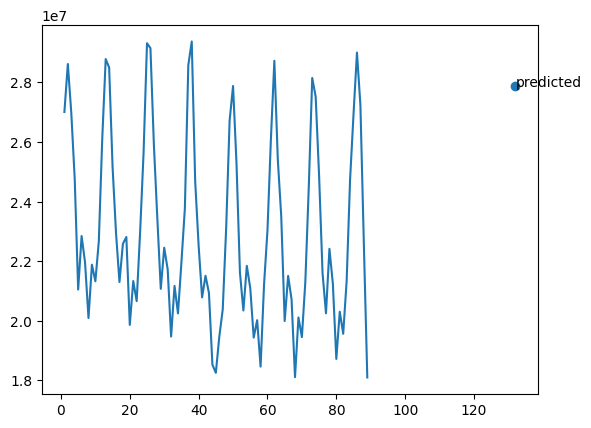

On average, CA demand in month 08 from 2014-2021 is 19175146.29, and the demand from month 08 of 2021 was 27525448.0
Predicted value: 27869201.23
This is an increase of 343753.23 from 2021


In [1440]:
demand, demand_diff = get_context(demand, predicted_demand, 'demand')

**Predicting emissions**

From 2_emissions_prediction.ipynb. Using previously generated vehicle distribution and predicted demand, predict final monthly emissions for the given date

In [1441]:
# Get dataset
df = demand.merge(emissions)
df = df.merge(vehicles)
df = df.drop(columns=['total','date_idx','date'])
df.head()

,demand,emissions,electric,plug-in hybrid electric,fuel cell,diesel,flex fuel,gasoline,gasoline hybrid,natural gas fuel,propane
0,22418337,4959996.71,522445,305315,10127,590216,1208970,25998618,1298275,8461,90
1,20251317,4365100.13,505951,300973,9877,599395,1203600,25917181,1285769,8395,157
2,21604672,4577134.35,490400,297256,9627,608574,1198231,25835745,1275167,8330,224
3,24859626,5070292.57,476248,292462,9377,617753,1192861,25754308,1263823,8264,291
4,27525448,5607233.68,462251,289169,9127,626932,1187492,25672872,1253083,8199,359


In [1442]:
# Gradient boosting regressor. Input: demand, vehicle distributions; output: emissions

X = df.drop(columns=['emissions'])
y = df['emissions']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

gb_model = GradientBoostingRegressor(n_estimators=50,min_samples_split=20,min_samples_leaf=4,max_features='sqrt',max_depth=3)
gb_model.fit(X_train,  y_train)

print(f'Input: {list(X.columns)}')
print(f'Training data score: {gb_model.score(X_train,  y_train)}')
print(f'Testing data score: {gb_model.score(X_test, y_test)}')

Input: ['demand', 'electric', 'plug-in hybrid electric', 'fuel cell', 'diesel', 'flex fuel', 'gasoline', 'gasoline hybrid', 'natural gas fuel', 'propane']
Training data score: 0.9108754195115458
Testing data score: 0.6891416831762894


In [1443]:
# Lasso

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lasso = Lasso(alpha=1.0)
lasso.fit(X_train, y_train)

print(f'Training data score: {lasso.score(X_train,  y_train)}')
print(f'Testing data score: {lasso.score(X_test, y_test)}')

Training data score: 0.6776635902743109
Testing data score: 0.6267093969613656


In [1444]:
estimators = [
    ("Lasso", lasso),
    ("Gradient Boosting", gb_model),
]

emissions_model = StackingRegressor(estimators=estimators, final_estimator=RidgeCV())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

emissions_model.fit(X,y)
print(f'Training data score: {emissions_model.score(X_train,  y_train)}')
print(f'Testing data score: {emissions_model.score(X_test, y_test)}')


Training data score: 0.862474793989788
Testing data score: 0.8655049731690819


In [1457]:
# use above model and vehicle distribution generated from previous step

def predict_emissions(emissions_model, emissions_input):
    prediction = emissions_model.predict([emissions_input])[0]
    return prediction

emissions_input = [predicted_demand] + list(vehicle_distribution.values())

predicted_emissions = predict_emissions(emissions_model, emissions_input)
print(f'The predicted monthly emissions in California is {round(predicted_emissions,2)} metric tons of CO2')

The predicted monthly emissions in California is 5717865.64 metric tons of CO2


**In context**

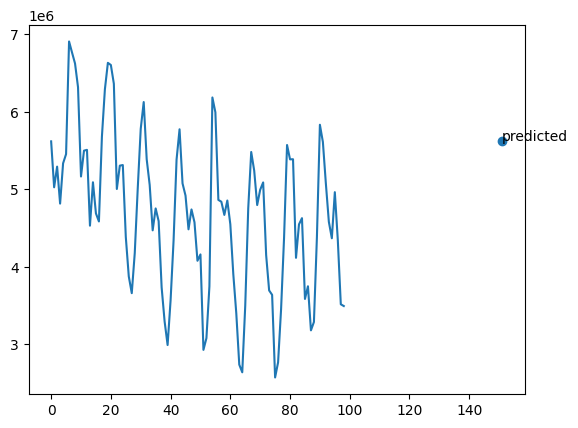

On average, CA emissions in month 08 from 2014-2021 is 5528633.55, and the emissions from month 08 of 2021 was 5607233.68
Predicted value: 5624180.8
This is an increase of 16947.12 from 2021


In [1446]:
emissions, emissions_diff = get_context(emissions, predicted_emissions, 'emissions')

In [1447]:
# Compare with emissions if we had additional gasoline cars rather than EVs

def get_gasoline_comparision(month, vehicles, vehicle_distribution, emissions_diff):
# get number of EV from given month of 2021
    prev_year =  MOST_RECENT_YEAR + month
    prev_evs = int(vehicles.loc[vehicles['date'] == int(prev_year), 'electric'])
    diff_evs = vehicle_distribution['electric'] - prev_evs

    AVG_YEARLY_CAR_EMISSIONS = 4.6 # mTCO2
    equ_gasoline_emissions = AVG_YEARLY_CAR_EMISSIONS/12 * diff_evs

    print(f'With these predicted vehicle numbers, there would be an increase of {diff_evs} EVs from 2021, with an increased emissions quantity of {round((emissions_diff),2)} mTCO2')
    print(f'For that same number of gasoline cars, we would estimate emissions of {round(equ_gasoline_emissions,2)} mTCO2')
    print(f'This is a saving of {round(equ_gasoline_emissions-emissions_diff,2)} mTCO2 for the state of California for month {month} of {str(date)[0:4]}')

month = str(date)[4:]
get_gasoline_comparision(month, vehicles, vehicle_distribution, emissions_diff)

With these predicted vehicle numbers, there would be an increase of 237584 EVs from 2021, with an increased emissions quantity of 16947.12 mTCO2
For that same number of gasoline cars, we would estimate emissions of 91073.87 mTCO2
This is a saving of 74126.75 mTCO2 for the state of California for month 08 of 2026


**Optimistic EV growth**

We follow the same process for a vehicle distribution assuming a more optimistic EV growth rate and an eventual gasoline decline

In [1448]:
# input
date = 202608 # December 2026

fit_list = {
    'electric': 6, # 2: least optimistic growth, 6: extremely optimistic growth
    'plug-in hybrid electric': 3,
    'fuel cell': 3,
    'gasoline hybrid': 3,
    'flex fuel': 2,
    'gasoline': 3, # 2: neutral growth, 3: decline
    'diesel': 4,
    'natural gas fuel': 4,
    'propane': 4
}

# get vehicle prediction
test_date_idx, vehicle_distribution = predict_distribution(date, fit_list)

# get weather averages
tmax_avg, precip_avg = weather_avg(date)
print()
print(f'In month {str(date)[4:]}, average for 2015-2022:')
print(f'Max temperature : {round(tmax_avg,2)}')
print(f'Precipitation: {round(precip_avg,2)}')

In month 8 of 2026 or date index 151, we predict:
Total vehicles: 27741933
Estimated number of electric vehicles: 1009995 or 3.64%
Estimated number of plug-in hybrid electric vehicles: 312033 or 1.12%
Estimated number of fuel cell vehicles: 12573 or 0.05%
Estimated number of diesel vehicles: 379989 or 1.37%
Estimated number of flex fuel vehicles: 1224642 or 4.41%
Estimated number of gasoline vehicles: 23517676 or 84.77%
Estimated number of gasoline hybrid vehicles: 1276945 or 4.6%
Estimated number of natural gas fuel vehicles: 8080 or 0.03%
Estimated number of propane vehicles: 0 or 0.0%

In month 08, average for 2015-2022:
Max temperature : 88.93
Precipitation: 0.1


In [1449]:
demand_input = [vehicle_distribution['electric'],vehicle_distribution['plug-in hybrid electric'],tmax_avg, precip_avg]
predicted_demand = predict_demand(demand_model, demand_input)

print(f'The predicted monthly demand in California is {round(predicted_demand,2)} MWh')

The predicted monthly demand in California is 28027557.14 MWh


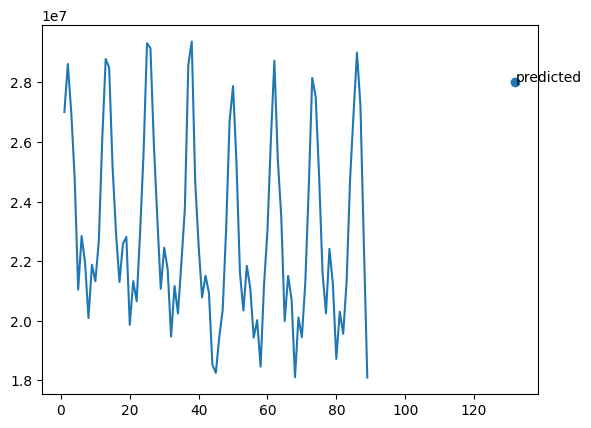

On average, CA demand in month 08 from 2014-2021 is 19175146.29, and the demand from month 08 of 2021 was 27525448.0
Predicted value: 28027557.14
This is an increase of 502109.14 from 2021


In [1450]:
demand, demand_diff = get_context(demand, predicted_demand, 'demand')

In [1456]:
emissions_input = [predicted_demand] + list(vehicle_distribution.values())

predicted_emissions = predict_emissions(emissions_model, emissions_input)
print(f'The predicted monthly emissions in California is {round(predicted_emissions,2)} metric tons of CO2')

The predicted monthly emissions in California is 5717865.64 metric tons of CO2


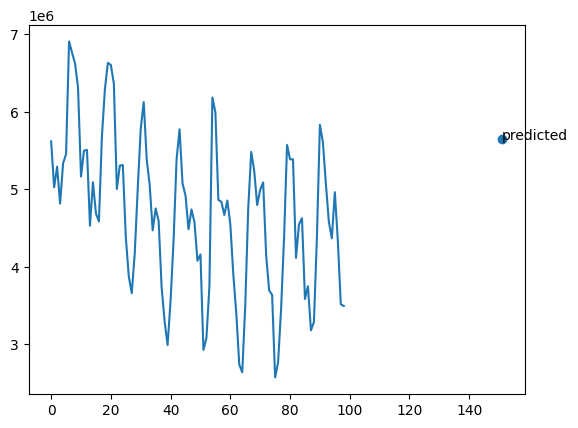

On average, CA emissions in month 08 from 2014-2021 is 5528633.55, and the emissions from month 08 of 2021 was 5607233.68
Predicted value: 5640539.45
This is an increase of 33305.77 from 2021


In [1452]:
emissions, emissions_diff = get_context(emissions, predicted_emissions, 'emissions')

In [1453]:
month = str(date)[4:]
get_gasoline_comparision(month, vehicles, vehicle_distribution, emissions_diff)

With these predicted vehicle numbers, there would be an increase of 547744 EVs from 2021, with an increased emissions quantity of 33305.77 mTCO2
For that same number of gasoline cars, we would estimate emissions of 209968.53 mTCO2
This is a saving of 176662.76 mTCO2 for the state of California for month 08 of 2026
